# H2O - Random Forest

<img src="https://media.sketchfab.com/models/e181944932084b5dbb4d5b625a5e9b10/thumbnails/a3f7c855d7ac412a8ed69dfb7ba6e36a/9dfc7c20975945c390dd5f01b6b78df9.jpeg">

## 0. Loading required libraries

In [1]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
start_time = time.time()
    
import os
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,22 mins 29 secs
H2O_cluster_timezone:,Europe/Kiev
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.2
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_anastasiia_kostiv_d9fy77
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.995 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


## 1. Helper modules for Descriptive Statistics

In [4]:
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

In [5]:
def get_top_abs_correlations(df, n=5): 
    au_corr = df.corr().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [6]:
def corrank(X):
    import itertools
    df = pd.DataFrame([[(i,j), 
                X.corr().loc[i,j]] for i,j in list(itertools.combinations(X.corr(), 2))],
                columns=['pairs','corr'])
    print(df.sort_values(by='corr',ascending=False))
    print()

In [7]:
# Helper module for Label Encoding for Categorical Features
def dummyEncode(df):
    columnsToEncode = list(df.select_dtypes(include=['category', 'object']))
    le = LabelEncoder()
    for feature in columnsToEncode:
        try:
            if(feature == 'Churn'):
                pass
            else:
                df[feature] = le.fit_transform(df[feature])
        except:
            print('Error encoding '+feature)
    return df

## 2. Loading dataset

In [8]:
def load_dataset(filename):
        
    dataset = pd.read_csv(filename, sep = ',')
        
    print(dataset.shape);    print(dataset.head(5));    print(dataset.columns);
    print(dataset.dtypes)
        
    feature_names = ['Account_Length', 'Vmail_Message', 'Day_Mins', 'Eve_Mins', 
    'Night_Mins','Intl_Mins', 'CustServ_Calls', 'Intl_Plan', 'Vmail_Plan',
    'Day_Calls', 'Day_Charge', 'Eve_Calls', 'Eve_Charge', 'Night_Calls',
    'Night_Charge', 'Intl_Calls', 'Intl_Charge', 'State', 'Area_Code']
        
    target = 'Churn'
        
    dataset = dummyEncode(dataset[['Account_Length', 'Vmail_Message', 'Day_Mins', 'Eve_Mins', 
    'Night_Mins','Intl_Mins', 'CustServ_Calls', 'Intl_Plan', 'Vmail_Plan',
    'Day_Calls', 'Day_Charge', 'Eve_Calls', 'Eve_Charge', 'Night_Calls',
    'Night_Charge', 'Intl_Calls', 'Intl_Charge', 'State', 'Area_Code', 'Churn']])
        
    return feature_names, target, dataset

## 3. Find missing values in dataset if exists

In [9]:
    def find_miising_value(feature_names, target, dataset):
        
        print()
        print('#---------------------------------------------------------------')
        print('Check for Mising Value or NaN Value in the Dataset')
        print('#---------------------------------------------------------------')
        # Method - 1
        # Count Number of Missing Value on Each Column    
        print('\nCount Number of Missing Value on Each Column: ')        
        print(dataset.isnull().sum(axis=0))

        # Method - 2
        # Check if there are any missing values in Dataset
        feature_count = dataset.columns[dataset.isnull().sum() != 0].size
        print()
        print("Total Features with missing Values = " + str(feature_count))

        if (feature_count):
            print()
            print("Features with NaN => {}".format(list(dataset.columns[dataset.isnull().sum() != 0])))
            print('Count Number of Missing Value on Each Column: ')        
            print(dataset[dataset.columns[dataset.isnull().sum() != 0]].isnull().sum().sort_values(ascending = False))

        print()
        print('#---------------------------------------------------------------')
        print('Check and Remove constant columns in the Dataset')
        print('#---------------------------------------------------------------')
        colsToRemove = []
        for col in dataset.columns:
            if col not in ['Churn']:
                if dataset[col].std() == 0: 
                    colsToRemove.append(col)
        print()
        print("Removed `{}` Constant Columns: ".format(len(colsToRemove)))
        print(colsToRemove)
        # remove constant columns in the Dataset
        dataset.drop(colsToRemove, axis=1, inplace=True)

        print()
        print('#---------------------------------------------------------------')
        print('Check and Remove Duplicate Columns in the Dataset')
        print('#---------------------------------------------------------------')
        print()
        print(dataset.columns); print(dataset.head(5))
        print('\nDuplicate Columns in the Dataset: \n', dataset.columns.duplicated())        
        dataset = dataset.loc[:, ~dataset.columns.duplicated()]
        print()
        print(dataset.columns); print(dataset.head(5))
        
        print()
        print('#---------------------------------------------------------------')
        print('Check and Drop Sparse Data/Columns in the Dataset')
        print('#---------------------------------------------------------------')
        flist = [x for x in dataset.columns if not x in ['Churn']]
        print(); print(flist)
        for f in flist:
            if len(np.unique(dataset[f])) < 2:
                print('Feature contains Sparse Data: ', f)
                dataset.drop(f, axis=1, inplace=True)
        print()
        print(dataset.columns); print(dataset.head(5))
        
        # --------------------------------------------------
        # Missing Values treatment in the DataSet (if any)
        # --------------------------------------------------    

        # Filling NULL values according to their dataTypes
        # Group Dataset according to different dataTypes
        gd = dataset.columns.to_series().groupby(dataset.dtypes).groups
        print('\nGroup Columns according to their dataTypes: \n', gd)  
        colNames = dataset.columns.values.tolist()
        for colName in colNames:
            if dataset[colName].dtypes == 'int64':
                dataset[colName] = dataset[colName].fillna(0)
            if dataset[colName].dtypes == 'float64':
                dataset[colName] = dataset[colName].fillna(0.0) 
            if dataset[colName].dtypes == 'object':
                dataset[colName] = dataset[colName].fillna('Unknown')    

        ## Count Number of Missing Value on Each Column    
        print('\nCount Number of Missing Value on Each Column: ')        
        print(dataset.isnull().sum(axis=0))

        # Check if there are any missing values in Dataset
        feature_count = dataset.columns[dataset.isnull().sum() != 0].size
        print()
        print("Total Features with missing Values = " + str(feature_count))
        
        return(dataset)

## 4. Descriptive statistics and correlation matrix

In [10]:
def data_descriptiveStats(feature_names, target, dataset):
    # Count Number of Missing Value on Each Column    
    print(); print('Count Number of Missing Value on Each Column: ')        
    print(); print(dataset[feature_names].isnull().sum(axis=0))
    print(); print(dataset[target].isnull().sum(axis=0))    
    
    # Get Information on the feature variables
    print(); print('Get Information on the feature variables: ')            
    print(); print(dataset[feature_names].info())
    print(); print(dataset[feature_names].describe())
    
    # correlation
    pd.set_option('precision', 2)
    print(); print(dataset[feature_names].corr())    
    
    # Ranking of Correlation Coefficients among Variable Pairs
    print(); print("Ranking of Correlation Coefficients:")    
    corrank(dataset[feature_names])

    # Print Highly Correlated Variables
    print(); print("Highly correlated variables (Absolute Correlations):")
    print(); print(get_top_abs_correlations(dataset[feature_names], 8))
    
    # Get Information on the target    
    print(); print(dataset[target].describe())    
    print(); print(dataset.groupby(target).size())   

## 5. Data visualisation and correlation graph

In [11]:
    def data_visualization(feature_names, target, dataset):
        # BOX plots USING box and whisker plots
        i = 1
        print(); print('BOX plot of each numerical features')
        plt.figure(figsize=(11,9))     
        for col in feature_names:
            plt.subplot(4,5,i)
            plt.axis('on')
            plt.tick_params(axis='both', left=True, top=False, right=False, bottom=True, 
                            labelleft=False, labeltop=False, labelright=False, labelbottom=False)
            dataset[col].plot(kind='box', subplots=True, sharex=False, sharey=False)
            i += 1
        plt.show()    
    
        # USING histograms
        j = 1
        print(); print('Histogram of each Numerical Feature')
        plt.figure(figsize=(11,9))     
        for col in feature_names:
            plt.subplot(4,5,j)
            plt.axis('on')
            plt.tick_params(axis='both', left=True, top=False, right=False, bottom=False, 
                            labelleft=False, labeltop=False, labelright=False, labelbottom=False)
            dataset[col].hist()
            j += 1
        plt.show()

        # correlation matrix
        print(); print('Correlation Matrix of All Numerical Features')   
        fig = plt.figure(figsize=(11,9))
        ax = fig.add_subplot(111)
        cax = ax.matshow(dataset[feature_names].corr(), vmin=-1, vmax=1, interpolation='none')
        fig.colorbar(cax)
        ticks = np.arange(0,19,1)
        ax.set_xticks(ticks)
        ax.set_yticks(ticks)
        plt.show()

        # Correlation Plot using seaborn
        print(); print("Correlation plot of Numerical features")
        # Compute the correlation matrix
        corr = dataset[feature_names].corr()
        print(corr)
        # Generate a mask for the upper triangle
        mask = np.zeros_like(corr, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
        # Set up the matplotlib figure
        f, ax = plt.subplots(figsize=(11, 9))
        # Generate a custom diverging colormap
        cmap = sns.diverging_palette(220, 10, as_cmap=True)
        # Draw the heatmap with the mask and correct aspect ratio
        sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, vmin= -1.0, center=0, square=True, 
                    linewidths=.5, cbar_kws={"shrink": .5})
        plt.show()    
    
        # Pie chart for Categorical Variables
        print(); print('PIE Chart of for Target: ')
        plt.figure(figsize=(11,9)) 
        i = 1
        for colName in [target]:
            labels = []; sizes = [];
            df = dataset.groupby(colName).size()
            for key in df.keys():
                labels.append(key)
                sizes.append(df[key])
            # Plot PIE Chart with %
            plt.subplot(2,2,i)
            plt.axis('on')
            plt.tick_params(axis='both', left=False, top=False, right=False, bottom=False, 
                            labelleft=True, labeltop=True, labelright=False, labelbottom=False)        
            plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=140)
            plt.axis('equal')
            i += 1; plt.savefig('Piefig.pdf', format='pdf')
        plt.show()    

## 6. Data split to train and test datasets

In [12]:
    def data_split(feature_names, target, dataset):
        
        hf = h2o.H2OFrame(dataset)
        
        print()
        print(hf.describe())
        print(hf.columns)
        print(hf.head())
        print(hf.tail())
        
        # Data Transform - Split train : test datasets
        train, valid = hf.split_frame(ratios = [.66], seed = 1234)
        print("Training Dataset", train.shape)
        print("Validation Dataset", valid.shape)        

        return train, valid

In [13]:
    def training_model(train, valid, feature_names, target):
        
        from h2o.estimators.random_forest import H2ORandomForestEstimator
        rf_classifier = H2ORandomForestEstimator(seed = 1234, 
                                                      distribution = "multinomial")
        rf_classifier.train(x=feature_names, y=target, 
                             training_frame = train, validation_frame = valid, 
                             verbose = False)

        print(rf_classifier.show())
        return(rf_classifier)

## 7. Make Prediction

In [14]:
    def save_model(model):
        
        print(model.show())
        
        # save the model
        model_path = h2o.save_model(model=model, path=os.getcwd(), force=True)
        
        return(model_path)

In [15]:
    def final_prediction(feature_names, test_filename, model_path):

        print("********************************************************************")
        print(format(' Final Prediction ','*^65'))
        print("********************************************************************")
        
        # load model
        model = h2o.load_model(model_path)
        
        # load dataset
        dataset = pd.read_csv(filename, sep = ',')

        print(dataset.shape);    print(dataset.head(5));    print(dataset.columns);
        print(dataset.dtypes)
        
        data = dummyEncode(dataset)
        hf = h2o.H2OFrame(data)
        
        # final prediction and results
        predicted_class     = model.predict(hf[feature_names])
        print(predicted_class['predict'])
        
        data = predicted_class.as_data_frame()
        data.to_csv('FinalResult.csv', index = False)

        # Evaluate the skill of the Trained model
        acc                 = accuracy_score(dataset['Churn'], data['predict'])
        classReport         = classification_report(dataset['Churn'], data['predict'])
        confMatrix          = confusion_matrix(dataset['Churn'], data['predict']) 
        kappa_score         = cohen_kappa_score(dataset['Churn'], data['predict'])         
        
        print(); print('Testing Results of the trained model: ')
        print(); print('Accuracy : ', acc)
        print(); print('Kappa Score : ', kappa_score)
        print(); print('Confusion Matrix :\n', confMatrix)
        print(); print('Classification Report :\n',classReport)

        # Confusion matrix
        skplt.metrics.plot_confusion_matrix(dataset['Churn'],
                                            data['predict'],figsize=(7,7)); 
        plt.show()

## 8. Execute algorithm using functions above


Execution Time 1599332256.425285 seconds: 
(3333, 21)
   Account_Length  Vmail_Message  Day_Mins  Eve_Mins  Night_Mins  Intl_Mins  \
0             128             25     265.1     197.4       244.7       10.0   
1             107             26     161.6     195.5       254.4       13.7   
2             137              0     243.4     121.2       162.6       12.2   
3              84              0     299.4      61.9       196.9        6.6   
4              75              0     166.7     148.3       186.9       10.1   

   CustServ_Calls Churn Intl_Plan Vmail_Plan  ...  Day_Charge  Eve_Calls  \
0               1    no        no        yes  ...       45.07         99   
1               1    no        no        yes  ...       27.47        103   
2               0    no        no         no  ...       41.38        110   
3               2    no       yes         no  ...       50.90         88   
4               3    no       yes         no  ...       28.34        122   

   Eve_Charge

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.



#---------------------------------------------------------------
Check for Mising Value or NaN Value in the Dataset
#---------------------------------------------------------------

Count Number of Missing Value on Each Column: 
Account_Length    0
Vmail_Message     0
Day_Mins          0
Eve_Mins          0
Night_Mins        0
Intl_Mins         0
CustServ_Calls    0
Intl_Plan         0
Vmail_Plan        0
Day_Calls         0
Day_Charge        0
Eve_Calls         0
Eve_Charge        0
Night_Calls       0
Night_Charge      0
Intl_Calls        0
Intl_Charge       0
State             0
Area_Code         0
Churn             0
dtype: int64

Total Features with missing Values = 0

#---------------------------------------------------------------
Check and Remove constant columns in the Dataset
#---------------------------------------------------------------

Removed `0` Constant Columns: 
[]

#---------------------------------------------------------------
Check and Remove Duplicate Columns i


Total Features with missing Values = 0

Count Number of Missing Value on Each Column: 

Account_Length    0
Vmail_Message     0
Day_Mins          0
Eve_Mins          0
Night_Mins        0
Intl_Mins         0
CustServ_Calls    0
Intl_Plan         0
Vmail_Plan        0
Day_Calls         0
Day_Charge        0
Eve_Calls         0
Eve_Charge        0
Night_Calls       0
Night_Charge      0
Intl_Calls        0
Intl_Charge       0
State             0
Area_Code         0
dtype: int64

0

Get Information on the feature variables: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 19 columns):
Account_Length    3333 non-null int64
Vmail_Message     3333 non-null int64
Day_Mins          3333 non-null float64
Eve_Mins          3333 non-null float64
Night_Mins        3333 non-null float64
Intl_Mins         3333 non-null float64
CustServ_Calls    3333 non-null int64
Intl_Plan         3333 non-null int64
Vmail_Plan        3333 non-null int64
Day_Calls    

Area_Code        -2.42e-02    -1.84e-02  1.58e-02   1.00e+00  

Ranking of Correlation Coefficients:
                           pairs  corr
42        (Day_Mins, Day_Charge)  1.00
59        (Eve_Mins, Eve_Charge)  1.00
75    (Night_Mins, Night_Charge)  1.00
90      (Intl_Mins, Intl_Charge)  1.00
24   (Vmail_Message, Vmail_Plan)  0.96
..                           ...   ...
103      (CustServ_Calls, State) -0.03
33        (Vmail_Message, State) -0.03
68       (Night_Mins, Intl_Plan) -0.03
111    (Intl_Plan, Night_Charge) -0.03
124          (Vmail_Plan, State) -0.03

[171 rows x 2 columns]


Highly correlated variables (Absolute Correlations):

Day_Mins       Day_Charge      1.00
Eve_Mins       Eve_Charge      1.00
Night_Mins     Night_Charge    1.00
Intl_Mins      Intl_Charge     1.00
Vmail_Message  Vmail_Plan      0.96
Intl_Plan      Day_Charge      0.05
Day_Mins       Intl_Plan       0.05
Intl_Plan      Area_Code       0.05
dtype: float64

count     3333
unique       2
top         no
fr

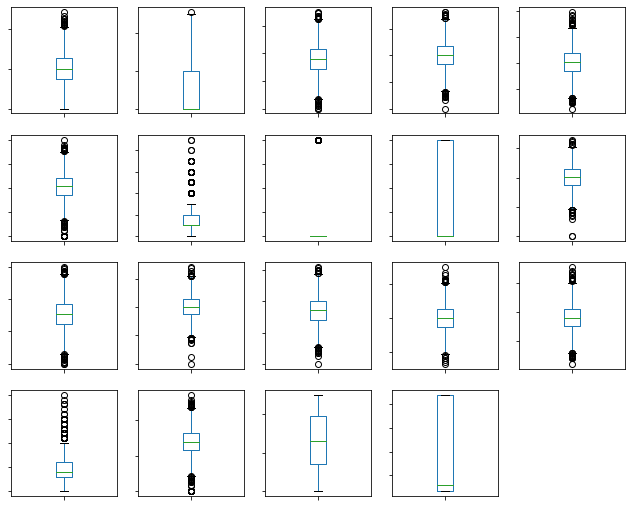


Histogram of each Numerical Feature


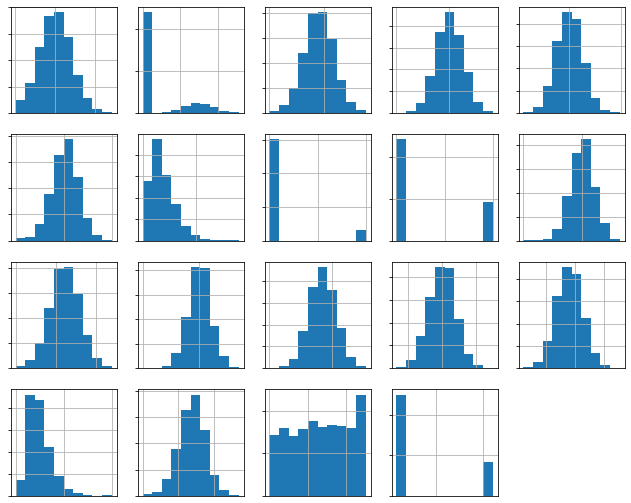


Correlation Matrix of All Numerical Features


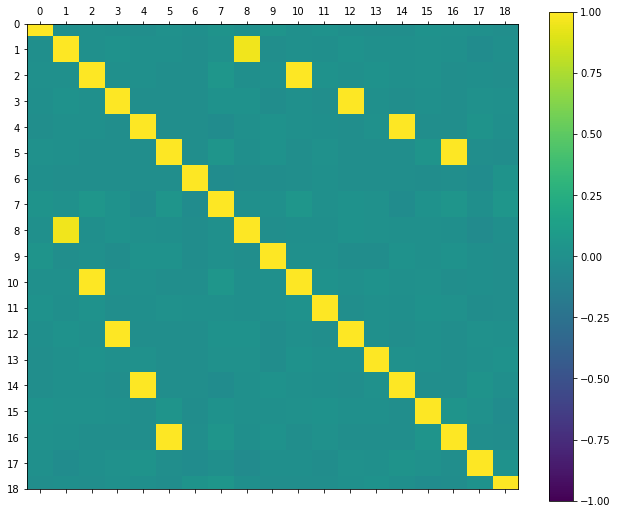


Correlation plot of Numerical features
                Account_Length  Vmail_Message  Day_Mins  Eve_Mins  Night_Mins  \
Account_Length        1.00e+00      -4.63e-03  6.22e-03 -6.76e-03   -8.96e-03   
Vmail_Message        -4.63e-03       1.00e+00  7.78e-04  1.76e-02    7.68e-03   
Day_Mins              6.22e-03       7.78e-04  1.00e+00  7.04e-03    4.32e-03   
Eve_Mins             -6.76e-03       1.76e-02  7.04e-03  1.00e+00   -1.26e-02   
Night_Mins           -8.96e-03       7.68e-03  4.32e-03 -1.26e-02    1.00e+00   
Intl_Mins             9.51e-03       2.86e-03 -1.02e-02 -1.10e-02   -1.52e-02   
CustServ_Calls       -3.80e-03      -1.33e-02 -1.34e-02 -1.30e-02   -9.29e-03   
Intl_Plan             2.47e-02       8.75e-03  4.94e-02  1.91e-02   -2.89e-02   
Vmail_Plan            2.92e-03       9.57e-01 -1.68e-03  2.15e-02    6.08e-03   
Day_Calls             3.85e-02      -9.55e-03  6.75e-03 -2.15e-02    2.29e-02   
Day_Charge            6.21e-03       7.76e-04  1.00e+00  7.05e-03    

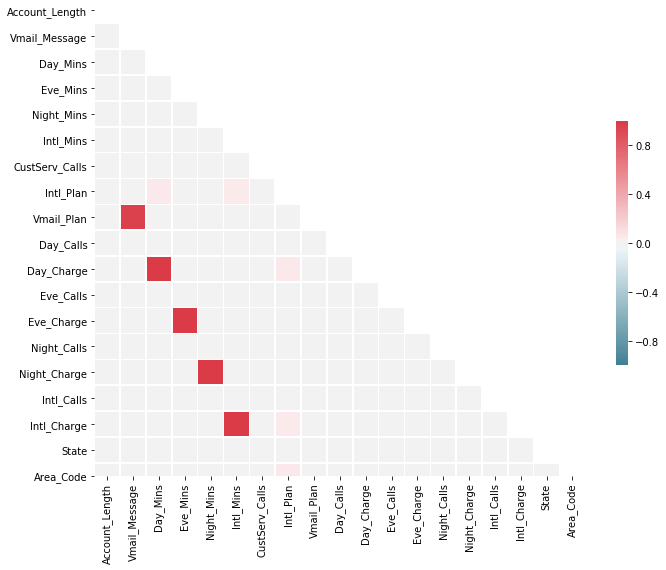


PIE Chart of for Target: 


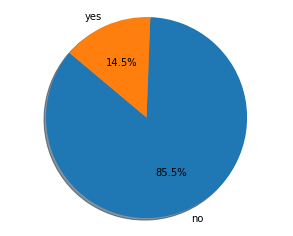

Parse progress: |█████████████████████████████████████████████████████████| 100%

Rows:3333
Cols:20




,Account_Length,Vmail_Message,Day_Mins,Eve_Mins,Night_Mins,Intl_Mins,CustServ_Calls,Intl_Plan,Vmail_Plan,Day_Calls,Day_Charge,Eve_Calls,Eve_Charge,Night_Calls,Night_Charge,Intl_Calls,Intl_Charge,State,Area_Code,Churn
type,int,int,real,real,real,real,int,int,int,int,real,int,real,int,real,int,real,int,int,enum
mins,1.0,0.0,0.0,0.0,23.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,1.04,0.0,0.0,0.0,408.0,
mean,101.06480648064796,8.099009900990088,179.77509750975116,200.98034803480365,200.8720372037203,10.237293729372912,1.5628562856285646,0.0969096909690969,0.27662766276627665,100.43564356435634,30.562307230723068,100.1143114311431,17.08354035403533,100.10771077107714,9.03932493249326,4.479447944794476,2.764581458145815,26.059405940594026,437.18241824182434,
maxs,243.0,51.0,350.8,363.7,395.0,20.0,9.0,1.0,1.0,165.0,59.64,170.0,30.91,175.0,17.77,20.0,5.4,50.0,510.0,
sigma,39.82210592859567,13.688365372038598,54.46738920237146,50.713844425811985,50.57384701365836,2.791839548408416,1.3154910448664752,0.2958791454844149,0.4473978703800635,20.069084207300897,9.259434553930495,19.92262529394312,4.310667643110347,19.568609346058544,2.275872837660027,2.4612142705460953,0.7537726126630452,14.824910875958794,42.37129048560661,
zeros,0,2411,2,1,0,18,697,3010,2411,2,2,1,1,0,0,18,18,52,0,
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,128.0,25.0,265.1,197.4,244.7,10.0,1.0,0.0,1.0,110.0,45.07,99.0,16.78,91.0,11.01,3.0,2.7,16.0,415.0,no
1,107.0,26.0,161.6,195.5,254.4,13.7,1.0,0.0,1.0,123.0,27.47,103.0,16.62,103.0,11.45,3.0,3.7,35.0,415.0,no
2,137.0,0.0,243.4,121.2,162.6,12.2,0.0,0.0,0.0,114.0,41.38,110.0,10.3,104.0,7.32,5.0,3.29,31.0,415.0,no


None
['Account_Length', 'Vmail_Message', 'Day_Mins', 'Eve_Mins', 'Night_Mins', 'Intl_Mins', 'CustServ_Calls', 'Intl_Plan', 'Vmail_Plan', 'Day_Calls', 'Day_Charge', 'Eve_Calls', 'Eve_Charge', 'Night_Calls', 'Night_Charge', 'Intl_Calls', 'Intl_Charge', 'State', 'Area_Code', 'Churn']


Account_Length,Vmail_Message,Day_Mins,Eve_Mins,Night_Mins,Intl_Mins,CustServ_Calls,Intl_Plan,Vmail_Plan,Day_Calls,Day_Charge,Eve_Calls,Eve_Charge,Night_Calls,Night_Charge,Intl_Calls,Intl_Charge,State,Area_Code,Churn
128,25,265.1,197.4,244.7,10,1,0,1,110,45.07,99,16.78,91,11.01,3,2.7,16,415,no
107,26,161.6,195.5,254.4,13.7,1,0,1,123,27.47,103,16.62,103,11.45,3,3.7,35,415,no
137,0,243.4,121.2,162.6,12.2,0,0,0,114,41.38,110,10.3,104,7.32,5,3.29,31,415,no
84,0,299.4,61.9,196.9,6.6,2,1,0,71,50.9,88,5.26,89,8.86,7,1.78,35,408,no
75,0,166.7,148.3,186.9,10.1,3,1,0,113,28.34,122,12.61,121,8.41,3,2.73,36,415,no
118,0,223.4,220.6,203.9,6.3,0,1,0,98,37.98,101,18.75,118,9.18,6,1.7,1,510,no
121,24,218.2,348.5,212.6,7.5,3,0,1,88,37.09,108,29.62,118,9.57,7,2.03,19,510,no
147,0,157,103.1,211.8,7.1,0,1,0,79,26.69,94,8.76,96,9.53,6,1.92,24,415,no
117,0,184.5,351.6,215.8,8.7,1,0,0,97,31.37,80,29.89,90,9.71,4,2.35,18,408,no
141,37,258.6,222,326.4,11.2,0,1,1,84,43.96,111,18.87,97,14.69,5,3.02,49,415,no


Account_Length,Vmail_Message,Day_Mins,Eve_Mins,Night_Mins,Intl_Mins,CustServ_Calls,Intl_Plan,Vmail_Plan,Day_Calls,Day_Charge,Eve_Calls,Eve_Charge,Night_Calls,Night_Charge,Intl_Calls,Intl_Charge,State,Area_Code,Churn
117,0,118.4,249.3,227,13.6,5,0,0,126,20.13,97,21.19,56,10.22,3,3.67,15,415,yes
159,0,169.8,197.7,193.7,11.6,1,0,0,114,28.87,105,16.8,82,8.72,4,3.13,49,415,no
78,0,193.4,116.9,243.3,9.3,2,0,0,99,32.88,88,9.94,109,10.95,4,2.51,35,408,no
96,0,106.6,284.8,178.9,14.9,1,0,0,128,18.12,87,24.21,92,8.05,7,4.02,35,415,no
79,0,134.7,189.7,221.4,11.8,2,0,0,98,22.9,68,16.12,128,9.96,5,3.19,40,415,no
192,36,156.2,215.5,279.1,9.9,2,0,1,77,26.55,126,18.32,83,12.56,6,2.67,3,415,no
68,0,231.1,153.4,191.3,9.6,3,0,0,57,39.29,55,13.04,123,8.61,4,2.59,49,415,no
28,0,180.8,288.8,191.9,14.1,2,0,0,109,30.74,58,24.55,91,8.64,6,3.81,39,510,no
184,0,213.8,159.6,139.2,5,2,1,0,105,36.35,84,13.57,137,6.26,10,1.35,6,510,no
74,25,234.4,265.9,241.4,13.7,0,0,1,113,39.85,82,22.6,77,10.86,4,3.7,42,415,no



Training Dataset (2210, 20)
Validation Dataset (1123, 20)
drf Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1599330906248_664


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,97815.0,14.0,20.0,18.22,119.0,194.0,150.86




ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.050000408603898115
RMSE: 0.2236077114142044
LogLoss: 0.5387190824748186
Mean Per-Class Error: 0.11657509569541447
AUC: 0.9090572772675689
AUCPR: 0.8483411817542335
Gini: 0.8181145545351378

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4375: 


,,no,yes,Error,Rate
0,no,1858.0,35.0,0.0185,(35.0/1893.0)
1,yes,79.0,238.0,0.2492,(79.0/317.0)
2,Total,1937.0,273.0,0.0516,(114.0/2210.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.44,0.81,89.0
1,max f2,0.29,0.80,117.0
2,max f0point5,0.52,0.87,77.0
3,max accuracy,0.52,0.95,77.0
4,max precision,1.00,1.00,0.0
5,max recall,0.00,1.00,234.0
6,max specificity,1.00,1.00,0.0
7,max absolute_mcc,0.44,0.78,89.0
8,max min_per_class_accuracy,0.17,0.85,148.0
9,max mean_per_class_accuracy,0.29,0.88,117.0



Gains/Lift Table: Avg response rate: 14,34 %, avg score: 14,56 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.01,0.94,6.97,6.97,1.00,9.76e-01,1.00,0.98,0.08,0.08,597.16,597.16,0.08
1,2,0.02,0.89,6.97,6.97,1.00,9.13e-01,1.00,0.95,0.06,0.14,597.16,597.16,0.14
2,3,0.03,0.86,6.97,6.97,1.00,8.69e-01,1.00,0.92,0.07,0.21,597.16,597.16,0.21
3,4,0.04,0.81,6.97,6.97,1.00,8.30e-01,1.00,0.90,0.07,0.28,597.16,597.16,0.28
4,5,0.05,0.78,6.97,6.97,1.00,7.92e-01,1.00,0.87,0.09,0.37,597.16,597.16,0.37
5,6,0.10,0.54,5.91,6.47,0.85,6.55e-01,0.93,0.77,0.28,0.65,490.93,546.69,0.64
6,7,0.15,0.31,3.01,5.28,0.43,4.23e-01,0.76,0.65,0.16,0.80,200.50,427.53,0.76
7,8,0.20,0.21,0.80,4.21,0.11,2.50e-01,0.60,0.56,0.04,0.84,-20.32,321.14,0.75
8,9,0.30,0.12,0.18,2.83,0.03,1.51e-01,0.41,0.42,0.02,0.86,-81.81,183.22,0.65
9,10,0.41,0.07,0.26,2.15,0.04,8.75e-02,0.31,0.33,0.03,0.89,-74.18,114.86,0.56




ModelMetricsBinomial: drf
** Reported on validation data. **

MSE: 0.0485913502320169
RMSE: 0.22043445790533045
LogLoss: 0.36092620899121863
Mean Per-Class Error: 0.10013407863428636
AUC: 0.9024530724779998
AUCPR: 0.8598419309312181
Gini: 0.8049061449559995

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5: 


,,no,yes,Error,Rate
0,no,949.0,8.0,0.0084,(8.0/957.0)
1,yes,43.0,123.0,0.259,(43.0/166.0)
2,Total,992.0,131.0,0.0454,(51.0/1123.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.50,0.83,28.0
1,max f2,0.32,0.83,38.0
2,max f0point5,0.52,0.91,27.0
3,max accuracy,0.52,0.96,27.0
4,max precision,1.00,1.00,0.0
5,max recall,0.00,1.00,94.0
6,max specificity,1.00,1.00,0.0
7,max absolute_mcc,0.52,0.81,27.0
8,max min_per_class_accuracy,0.30,0.84,39.0
9,max mean_per_class_accuracy,0.32,0.90,38.0



Gains/Lift Table: Avg response rate: 14,78 %, avg score: 14,74 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.01,0.94,6.77,6.77,1.00,9.63e-01,1.00,0.96,7.23e-02,0.07,576.51,576.51,0.07
1,2,0.03,0.86,6.77,6.77,1.00,8.79e-01,1.00,0.91,1.14e-01,0.19,576.51,576.51,0.19
2,3,0.03,0.83,6.77,6.77,1.00,8.40e-01,1.00,0.91,1.81e-02,0.20,576.51,576.51,0.20
3,4,0.04,0.80,6.77,6.77,1.00,8.19e-01,1.00,0.88,6.63e-02,0.27,576.51,576.51,0.27
4,5,0.06,0.74,6.77,6.77,1.00,7.62e-01,1.00,0.85,1.08e-01,0.38,576.51,576.51,0.38
5,6,0.11,0.54,6.31,6.54,0.93,6.28e-01,0.97,0.74,3.31e-01,0.71,530.64,554.33,0.71
6,7,0.16,0.32,2.68,5.37,0.40,4.12e-01,0.79,0.64,1.27e-01,0.84,168.05,437.34,0.80
7,8,0.22,0.18,0.10,3.91,0.01,2.23e-01,0.58,0.53,6.02e-03,0.84,-89.90,291.37,0.74
8,9,0.33,0.10,0.11,2.60,0.02,1.22e-01,0.38,0.39,1.20e-02,0.86,-89.35,160.34,0.62
9,10,0.49,0.06,0.15,1.80,0.02,6.76e-02,0.27,0.28,2.41e-02,0.88,-84.97,79.91,0.46




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2020-09-05 22:03:54,0.013 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2020-09-05 22:03:54,0.029 sec,1.0,0.33,3.70,0.81,0.46,3.91,0.11,0.33,3.78,0.79,0.49,4.24,0.11
2,,2020-09-05 22:03:54,0.039 sec,2.0,0.32,3.24,0.81,0.49,4.28,0.10,0.28,1.51,0.85,0.67,6.00,0.14
3,,2020-09-05 22:03:54,0.051 sec,3.0,0.32,3.07,0.80,0.50,4.42,0.11,0.25,0.95,0.89,0.76,6.65,0.07
4,,2020-09-05 22:03:54,0.063 sec,4.0,0.31,2.60,0.81,0.55,4.96,0.10,0.24,0.83,0.90,0.79,6.77,0.07
5,,2020-09-05 22:03:54,0.074 sec,5.0,0.31,2.47,0.81,0.53,4.81,0.12,0.24,0.78,0.90,0.79,6.77,0.06
6,,2020-09-05 22:03:54,0.087 sec,6.0,0.29,2.01,0.83,0.58,5.24,0.11,0.24,0.70,0.90,0.81,6.77,0.06
7,,2020-09-05 22:03:54,0.099 sec,7.0,0.29,1.81,0.84,0.61,5.36,0.11,0.23,0.69,0.91,0.83,6.77,0.06
8,,2020-09-05 22:03:54,0.112 sec,8.0,0.29,1.73,0.85,0.62,5.41,0.10,0.23,0.69,0.91,0.83,6.77,0.05
9,,2020-09-05 22:03:54,0.124 sec,9.0,0.27,1.46,0.86,0.66,5.70,0.09,0.23,0.66,0.91,0.84,6.77,0.05



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Day_Charge,1272.24,1.00,1.41e-01
1,Day_Mins,1250.92,0.98,1.39e-01
2,CustServ_Calls,1184.34,0.93,1.31e-01
3,Intl_Plan,697.11,0.55,7.74e-02
4,Eve_Charge,518.90,0.41,5.76e-02
5,Intl_Calls,485.30,0.38,5.39e-02
6,Eve_Mins,476.56,0.37,5.29e-02
7,Intl_Charge,409.83,0.32,4.55e-02
8,Intl_Mins,337.94,0.27,3.75e-02
9,Night_Mins,298.45,0.23,3.31e-02


None
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1599330906248_664


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,97815.0,14.0,20.0,18.22,119.0,194.0,150.86




ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.050000408603898115
RMSE: 0.2236077114142044
LogLoss: 0.5387190824748186
Mean Per-Class Error: 0.11657509569541447
AUC: 0.9090572772675689
AUCPR: 0.8483411817542335
Gini: 0.8181145545351378

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4375: 


,,no,yes,Error,Rate
0,no,1858.0,35.0,0.0185,(35.0/1893.0)
1,yes,79.0,238.0,0.2492,(79.0/317.0)
2,Total,1937.0,273.0,0.0516,(114.0/2210.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.44,0.81,89.0
1,max f2,0.29,0.80,117.0
2,max f0point5,0.52,0.87,77.0
3,max accuracy,0.52,0.95,77.0
4,max precision,1.00,1.00,0.0
5,max recall,0.00,1.00,234.0
6,max specificity,1.00,1.00,0.0
7,max absolute_mcc,0.44,0.78,89.0
8,max min_per_class_accuracy,0.17,0.85,148.0
9,max mean_per_class_accuracy,0.29,0.88,117.0



Gains/Lift Table: Avg response rate: 14,34 %, avg score: 14,56 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.01,0.94,6.97,6.97,1.00,9.76e-01,1.00,0.98,0.08,0.08,597.16,597.16,0.08
1,2,0.02,0.89,6.97,6.97,1.00,9.13e-01,1.00,0.95,0.06,0.14,597.16,597.16,0.14
2,3,0.03,0.86,6.97,6.97,1.00,8.69e-01,1.00,0.92,0.07,0.21,597.16,597.16,0.21
3,4,0.04,0.81,6.97,6.97,1.00,8.30e-01,1.00,0.90,0.07,0.28,597.16,597.16,0.28
4,5,0.05,0.78,6.97,6.97,1.00,7.92e-01,1.00,0.87,0.09,0.37,597.16,597.16,0.37
5,6,0.10,0.54,5.91,6.47,0.85,6.55e-01,0.93,0.77,0.28,0.65,490.93,546.69,0.64
6,7,0.15,0.31,3.01,5.28,0.43,4.23e-01,0.76,0.65,0.16,0.80,200.50,427.53,0.76
7,8,0.20,0.21,0.80,4.21,0.11,2.50e-01,0.60,0.56,0.04,0.84,-20.32,321.14,0.75
8,9,0.30,0.12,0.18,2.83,0.03,1.51e-01,0.41,0.42,0.02,0.86,-81.81,183.22,0.65
9,10,0.41,0.07,0.26,2.15,0.04,8.75e-02,0.31,0.33,0.03,0.89,-74.18,114.86,0.56




ModelMetricsBinomial: drf
** Reported on validation data. **

MSE: 0.0485913502320169
RMSE: 0.22043445790533045
LogLoss: 0.36092620899121863
Mean Per-Class Error: 0.10013407863428636
AUC: 0.9024530724779998
AUCPR: 0.8598419309312181
Gini: 0.8049061449559995

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5: 


,,no,yes,Error,Rate
0,no,949.0,8.0,0.0084,(8.0/957.0)
1,yes,43.0,123.0,0.259,(43.0/166.0)
2,Total,992.0,131.0,0.0454,(51.0/1123.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.50,0.83,28.0
1,max f2,0.32,0.83,38.0
2,max f0point5,0.52,0.91,27.0
3,max accuracy,0.52,0.96,27.0
4,max precision,1.00,1.00,0.0
5,max recall,0.00,1.00,94.0
6,max specificity,1.00,1.00,0.0
7,max absolute_mcc,0.52,0.81,27.0
8,max min_per_class_accuracy,0.30,0.84,39.0
9,max mean_per_class_accuracy,0.32,0.90,38.0



Gains/Lift Table: Avg response rate: 14,78 %, avg score: 14,74 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.01,0.94,6.77,6.77,1.00,9.63e-01,1.00,0.96,7.23e-02,0.07,576.51,576.51,0.07
1,2,0.03,0.86,6.77,6.77,1.00,8.79e-01,1.00,0.91,1.14e-01,0.19,576.51,576.51,0.19
2,3,0.03,0.83,6.77,6.77,1.00,8.40e-01,1.00,0.91,1.81e-02,0.20,576.51,576.51,0.20
3,4,0.04,0.80,6.77,6.77,1.00,8.19e-01,1.00,0.88,6.63e-02,0.27,576.51,576.51,0.27
4,5,0.06,0.74,6.77,6.77,1.00,7.62e-01,1.00,0.85,1.08e-01,0.38,576.51,576.51,0.38
5,6,0.11,0.54,6.31,6.54,0.93,6.28e-01,0.97,0.74,3.31e-01,0.71,530.64,554.33,0.71
6,7,0.16,0.32,2.68,5.37,0.40,4.12e-01,0.79,0.64,1.27e-01,0.84,168.05,437.34,0.80
7,8,0.22,0.18,0.10,3.91,0.01,2.23e-01,0.58,0.53,6.02e-03,0.84,-89.90,291.37,0.74
8,9,0.33,0.10,0.11,2.60,0.02,1.22e-01,0.38,0.39,1.20e-02,0.86,-89.35,160.34,0.62
9,10,0.49,0.06,0.15,1.80,0.02,6.76e-02,0.27,0.28,2.41e-02,0.88,-84.97,79.91,0.46




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2020-09-05 22:03:54,0.013 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2020-09-05 22:03:54,0.029 sec,1.0,0.33,3.70,0.81,0.46,3.91,0.11,0.33,3.78,0.79,0.49,4.24,0.11
2,,2020-09-05 22:03:54,0.039 sec,2.0,0.32,3.24,0.81,0.49,4.28,0.10,0.28,1.51,0.85,0.67,6.00,0.14
3,,2020-09-05 22:03:54,0.051 sec,3.0,0.32,3.07,0.80,0.50,4.42,0.11,0.25,0.95,0.89,0.76,6.65,0.07
4,,2020-09-05 22:03:54,0.063 sec,4.0,0.31,2.60,0.81,0.55,4.96,0.10,0.24,0.83,0.90,0.79,6.77,0.07
5,,2020-09-05 22:03:54,0.074 sec,5.0,0.31,2.47,0.81,0.53,4.81,0.12,0.24,0.78,0.90,0.79,6.77,0.06
6,,2020-09-05 22:03:54,0.087 sec,6.0,0.29,2.01,0.83,0.58,5.24,0.11,0.24,0.70,0.90,0.81,6.77,0.06
7,,2020-09-05 22:03:54,0.099 sec,7.0,0.29,1.81,0.84,0.61,5.36,0.11,0.23,0.69,0.91,0.83,6.77,0.06
8,,2020-09-05 22:03:54,0.112 sec,8.0,0.29,1.73,0.85,0.62,5.41,0.10,0.23,0.69,0.91,0.83,6.77,0.05
9,,2020-09-05 22:03:54,0.124 sec,9.0,0.27,1.46,0.86,0.66,5.70,0.09,0.23,0.66,0.91,0.84,6.77,0.05



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Day_Charge,1272.24,1.00,1.41e-01
1,Day_Mins,1250.92,0.98,1.39e-01
2,CustServ_Calls,1184.34,0.93,1.31e-01
3,Intl_Plan,697.11,0.55,7.74e-02
4,Eve_Charge,518.90,0.41,5.76e-02
5,Intl_Calls,485.30,0.38,5.39e-02
6,Eve_Mins,476.56,0.37,5.29e-02
7,Intl_Charge,409.83,0.32,4.55e-02
8,Intl_Mins,337.94,0.27,3.75e-02
9,Night_Mins,298.45,0.23,3.31e-02


None
********************************************************************
*********************** Final Prediction ************************
********************************************************************
(3333, 21)
   Account_Length  Vmail_Message  Day_Mins  Eve_Mins  Night_Mins  Intl_Mins  \
0             128             25     265.1     197.4       244.7       10.0   
1             107             26     161.6     195.5       254.4       13.7   
2             137              0     243.4     121.2       162.6       12.2   
3              84              0     299.4      61.9       196.9        6.6   
4              75              0     166.7     148.3       186.9       10.1   

   CustServ_Calls Churn Intl_Plan Vmail_Plan  ...  Day_Charge  Eve_Calls  \
0               1    no        no        yes  ...       45.07         99   
1               1    no        no        yes  ...       27.47        103   
2               0    no        no         no  ...       41.38        110   
3

predict
no
no
no
no
no
no
no
no
no
no




Testing Results of the trained model: 

Accuracy :  0.9840984098409841

Kappa Score :  0.9337281529577145

Confusion Matrix :
 [[2842    8]
 [  45  438]]

Classification Report :
               precision    recall  f1-score   support

          no       0.98      1.00      0.99      2850
         yes       0.98      0.91      0.94       483

    accuracy                           0.98      3333
   macro avg       0.98      0.95      0.97      3333
weighted avg       0.98      0.98      0.98      3333



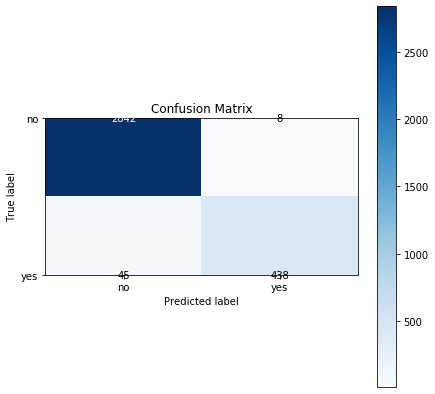


Execution Time 380.21617794036865 seconds: 


In [16]:
    if __name__ == '__main__':
        print()
        print("Execution Time %s seconds: " % (start_time))
        filename = 'TelcoCustomerChurnDataset.csv'
        
        feature_names, target, dataset = load_dataset(filename)
        dataset = find_miising_value(feature_names, target, dataset)
        data_descriptiveStats(feature_names, target, dataset)
        data_visualization(feature_names, target, dataset)
        train, valid = data_split(feature_names, target, dataset)
        model = training_model(train, valid, feature_names, target)
        model_path = save_model(model) 
        
        test_filename = 'TelcoCustomerChurnDataset.csv'
        final_prediction(feature_names, test_filename, model_path)
        
        print()
        print("Execution Time %s seconds: " % (time.time() - start_time))